In [1]:
from pandas.tseries.offsets import BDay
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import alphalens
import csv

# %matplotlib inline
import warnings
warnings.filterwarnings('ignore')

This notebook is for raw data file downloaded from io platform.

In [2]:
# This part is for reviewing the SQL code from io platform:

# 1. Load data & Pre-Filtering

In [3]:
# Take a look at data first.
# This is the close-to-close data from io
io_file = '3_22_rerun_automation_entity_relevance_filter_lt_70_without_story_source_filter.csv'
data_path = '/Users/brad_sun/Downloads/accern/accern_data/'
raw_io_og = pd.read_csv(data_path+io_file)

In [4]:
# This part is cutomized/optional, e.g. onluy want rows that have counts larger 10 or stuff like this
def pre_filtering(df, col, num):
    df = df[col] > num
    return df

# 2. Signal Buiding

In [1]:
# This part is customized for bulding signals for later use, separated from the next part which is aggregated together.
def build_signals(df, time_col, signal_col, build_signal):
    if build_signal == True:
        df['ent_sent'] = df.groupby([time_col])['avg_sentiment'].rank(ascending=True)
        df['eve_sent'] = df.groupby([time_col])['avg_event_sentiment'].rank(ascending=True)
        df['timeliness'] = df.groupby([time_col])['avg_entity_source_timeliness_score'].rank(ascending=True)
        df['traffic_sum'] = df.groupby([time_col])['avg_story_group_traffic_sum'].rank(ascending=True)
        df[signal_col] = (2*df['ent_sent'])+df['eve_sent']+df['timeliness']+df['traffic_sum']
        df[signal_col]=df[signal_col]/5
    else:
        df = df
    return df

# 3. Data Processing & QA

In [6]:
####################################### Completed on 3_23_2018 #######################################

# This part is for taking an initial look at entity_ticker count distribution across dataset's timeframe:
def entity_temporal_distribution(df, time_col, entity_col, start_date, end_date, freq):
    entity_count = df.groupby(time_col)[entity_col].count()
    entity_count_df = pd.DataFrame(entity_count)
    entity_count_df.columns = ['entity_count']
    entity_count_df.plot.bar(figsize = (14, 4))
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    plt.title('Dataset Entity Count Coverage', fontsize = 14)
    plt.ylabel('Entity Ticker Count Per {}'.format(freq))
    plt.xlabel('Timeframe: {} to {}'.format(start_date, end_date))
    
# Compare different lengths of dataframe by dropping NaNs and duplicates
def dropna_dropduplicates(df):
    print ('Before dropping NaNs, the length of df: ', len(df))
    NaNs_dropped = df.dropna()
    print ('After dropping NaNs, the length of df: ', len(NaNs_dropped))
    duplicates_dropped = df.drop_duplicates()
    print ('After dropping duplicates, the length of df: ', len(duplicates_dropped))
    both_dropped = NaNs_dropped.drop_duplicates()
    print ('After dropping NaNs and duplicates, the length of df: ', len(both_dropped))
    return both_dropped

# Trim dateframe based on a certain selected timeframe
def trim_timeframe(df, time_col, start_date, end_date):
    df = df[(df[time_col]>=start_date)&(df[time_col]<=end_date)]
    return df

# Show part of the dataframe
def show_df_head_tail(df):
    print ('The first two rows: ')
    print ('The last two rows: ')
    return df.head(2), df.tail(2)
    
# Plot temporal distribution of the processed siganl data
def signal_temporal_distribution_df(df, time_col, score_col, start_date, end_date, freq):
    signal_count = df.groupby(time_col)[score_col].count()
    signal_count_df = pd.DataFrame(signal_count)
    signal_count_df.columns = ['signal_count']
    signal_count_df.plot.bar(figsize = (14, 4))
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
    plt.title('Processed Dataset Signal Count Coverage', fontsize = 14)
    plt.ylabel('Signal Count Per {}'.format(freq))
    plt.xlabel('Timeframe: {} to {}'.format(start_date, end_date))
                       
# Plot basic stats and plotting of the data. 
def data_hist_plot(df, col):
    df[col].hist(bins=50, figsize=(12, 4))
    plt.title('Distribution on "{}"'.format(col), fontsize = 14)
    plt.xlabel('{}'.format(col))
    plt.ylabel('{} Total Frequency'.format(col))            
            
# This ticker info is downloaded from Wikipedia:
def entity_sector_QA(df, entity_col, signal_col):
    ticker_info = pd.read_csv(data_path+'sp500_csv_list.csv')
    ticker_sector_mapping = {}
    for i, row in enumerate(ticker_info['Ticker symbol']):
        ticker_sector_mapping[ticker_info['Ticker symbol'][i]] = ticker_info['GICS Sector'][i]
    df['sectors'] = df[entity_col].map(ticker_sector_mapping)
    print ('Total Unique Entity Tickers: ', df[entity_col].nunique())
    print ('Total Unique Sectors: ', df['sectors'].nunique())
    print ('Total rows of tickers: ', len(df[entity_col]))
    print ('Total rows of sectors: ', len(df['sectors']))
    print ('*'*60)
    print ('10 stocks with the LEAST signals; number of signals: ') 
    print (df.groupby([entity_col])[signal_col].count().sort_values().head(10))
    print ('*'*60)
    print ('10 stocks with the MOST signals; number of signals: ') 
    print (df.groupby([entity_col])[signal_col].count().sort_values().tail(10))
    print ('*'*60)
    print ('Total Signal Distribution - Sector-Wise - Stats')
    print (df.groupby(['sectors'])[signal_col].count())
    print ('*'*60)
    print ('Total Signal Distribution - Sector-Wise - Plot')
    df.groupby(['sectors'])[signal_col].count().plot.bar(figsize = (12, 4));        

# This part is for (if needed) reducing signal files to reduce number of stocks to trade on a daily basis.
# Mainly because of Quantopian's lack of capacity of loading large csv data file.
def reduce_size_for_Q(df, signal_col, reduce_down_to_num, time_col):
    top = df.dropna().sort_values(signal_col, ascending=False).groupby(time_col).head(reduce_down_to_num)
    bottom = df.dropna().sort_values(signal_col, ascending=False).groupby(time_col).tail(reduce_down_to_num)
    reduced_df = top.append(bottom)
    reduced_df = reduced_df.sort_values(time_col)
    reduced_df = reduced_df.drop_duplicates()
    return reduced_df    
    
# For open-open strategies, replace dates with the next dates to avoid forward-looking bias.
def replace_day_open_for_Q(df, time_col):
    df['next_day'] = pd.DatetimeIndex(df[time_col]) + pd.DateOffset(1)
    return df
    
# Convert the month to the next month start (first business day recognized by Quantopian)
def replace_month_start_open_for_Q(df, time_col):
    df['next_month'] = df[time_col].apply(lambda x: pd.bdate_range(start=x, periods=2, freq='BMS')[1])
    df['next_month'] = df['next_month'].apply(lambda x: str(x))
    # Pay attention here to the replace format since this could change because of our updates in the production data
    df['next_month'] = df['next_month'].apply(lambda x: x.replace(' 00:00:00+00:00', ''))
    df.replace('2013-09-02', '2013-09-03', inplace=True)
    df.replace('2014-01-01', '2014-01-02', inplace=True)
    df.replace('2014-09-01', '2014-09-02', inplace=True)
    df.replace('2015-01-01', '2015-01-02', inplace=True)
    df.replace('2016-01-01', '2016-01-04', inplace=True)
    df.replace('2017-01-02', '2017-01-03', inplace=True)
    df.replace('2018-01-01', '2018-01-02', inplace=True)
    df['next_month'] = pd.to_datetime(df['next_month'])
    return df 
    
# Convert to Quantopian's backtesting format.
def convert_to_Q_format(df, time_col, ticker_col):
    df['time'] = pd.to_datetime(df[time_col])
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    df['day'] = df['time'].dt.day
    df['symbol'] = df[ticker_col]
    return df

####################################### Updated on 3_29_2018 #######################################
# See each column's length and their plots for lengths, as well as total row number, updated on 3_29_2018
def column_stats(df):
    print ('Total length of the dataframe :', len(df))
    all_columns = df.columns
    col_value = {}
    for col in all_columns:
        col_value[col] = len(df[col].dropna())
    new_df = pd.DataFrame(list(col_value.values()), index = list(col_value.keys()), columns=['Non_Null_Length'])
    new_df.plot.bar(figsize = (12, 4))
    plt.legend(loc="best")
    return new_df

# Let's take a further look at what specific rows have these nan values. 
def get_nan_rows(df, col):
    nan_rows = df.loc[df[col].isnull()]
    print ('Total nan rows for column {}: '.format(col), len(nan_rows))
    return nan_rows


# Initialize everything here.
io_file = '3_22_rerun_automation_entity_relevance_filter_lt_70_without_story_source_filter.csv'
data_path = '/Users/brad_sun/Downloads/accern/accern_data/'
raw_io_og = pd.read_csv(data_path+io_file)

time_col = 'date'
entity_col = 'entity_ticker'
start_date = '2013-08-01'
col_to_drop = 'alphatrend_dst_score' # To clarify, not meaning drop this col.
score_col = 'alphatrend_dst_score'
signal_col = 'alphatrend_dst_score'
end_date = '2018-02-28'
freq = 'Day'
reduce_down_to_num = 60 

# 4. Initially Processed Data & Report Generating...

============================== QA PART 1 ==============================
Before dropping NaNs, the length of df:  583867
After dropping NaNs, the length of df:  456892
After dropping duplicates, the length of df:  583867
After dropping NaNs and duplicates, the length of df:  456892
============================== QA PART 2 ==============================
Generating Histogram on column "alphatrend_dst_score":
Generating Raw File Entity Ticker Counts...
Generating Processed Data File Signal Counts...


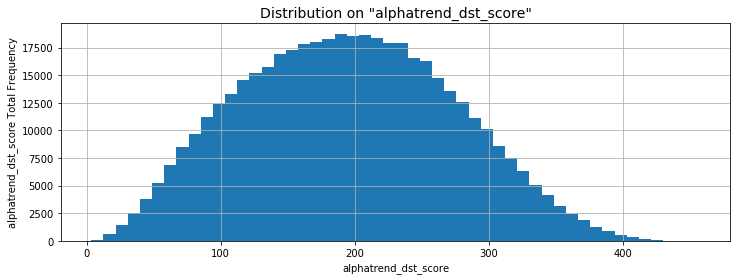

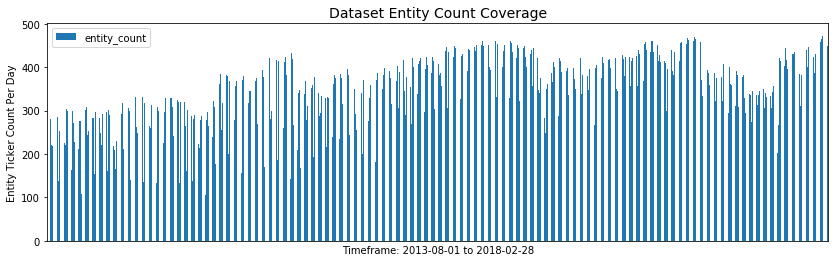

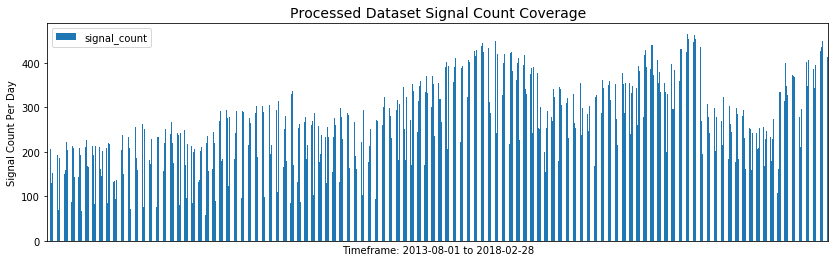

In [7]:
trimmed_df = trim_timeframe(raw_io_og, time_col, start_date, end_date)
signal_df = build_signals(trimmed_df, time_col, signal_col, False)
print ('============================== QA PART 1 ==============================')
cleaned_signal_df = dropna_dropduplicates(signal_df)
print ('============================== QA PART 2 ==============================')
print ('Generating Histogram on column "{}":'.format(signal_col))
data_hist_plot(cleaned_signal_df, signal_col)
print ('Generating Raw File Entity Ticker Counts...')
entity_temporal_distribution(trimmed_df, time_col, entity_col, start_date, end_date, freq)
print ('Generating Processed Data File Signal Counts...')
signal_temporal_distribution_df(cleaned_signal_df, time_col, score_col, start_date, end_date, freq)

In [8]:
print ('============================== QA PART 3 ==============================')
print ('Stats on column "{}":'.format(signal_col))
cleaned_signal_df[signal_col].dropna().describe()

============================== QA PART 3 ==============================
Stats on column "alphatrend_dst_score":


count    456892.000000
mean        195.225909
std          78.515489
min           3.400000
25%         135.600000
50%         194.200000
75%         252.200000
max         457.400000
Name: alphatrend_dst_score, dtype: float64

============================== QA PART 4 ==============================
Total Unique Entity Tickers:  490
Total Unique Sectors:  11
Total rows of tickers:  456892
Total rows of sectors:  456892
************************************************************
10 stocks with the LEAST signals; number of signals: 
entity_ticker
COTY    24
MKC     30
XRX     33
HLT     34
WRK     35
LUK     36
LEN     37
VAR     43
APD     46
HPE     48
Name: alphatrend_dst_score, dtype: int64
************************************************************
10 stocks with the MOST signals; number of signals: 
entity_ticker
NVDA    1673
BA      1673
FB      1673
GOOG    1673
NFLX    1673
TSCO    1673
MSFT    1673
INTC    1673
T       1673
VZ      1673
Name: alphatrend_dst_score, dtype: int64
************************************************************
Total Signal Distribution - Sector-Wise - Stats
sectors
Consumer Discretionary        77881
Consumer Staples              28478
Energy                        31034
Fi

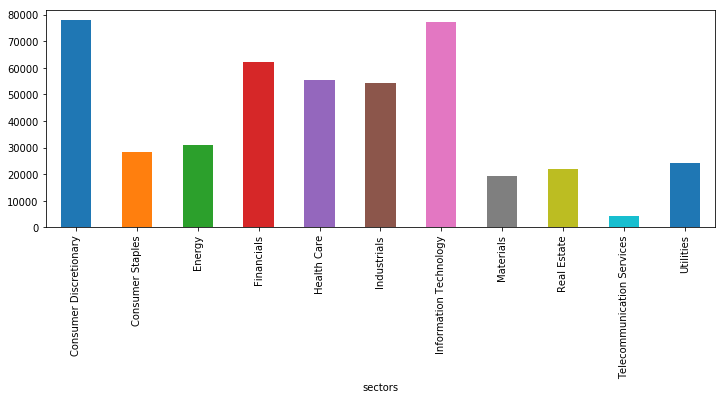

In [9]:
print ('============================== QA PART 4 ==============================')
entity_sector_QA(cleaned_signal_df, entity_col, signal_col)

# 5. (Optional Step) Reduce file size (for Quantopian)

In [160]:
reduce_size_for_Q?

In [176]:
reduced_sample_test = cleaned_signal_df.copy()
reduced_sample_test = reduce_size_for_Q(cleaned_signal_df, signal_col, reduce_down_to_num, time_col)

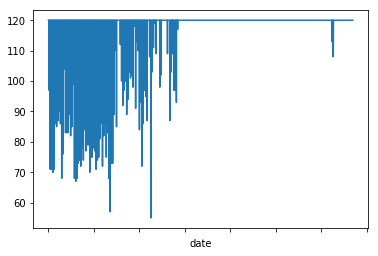

In [177]:
# Plot dataframe to see if it works well.
reduced_sample_test.groupby(time_col)[signal_col].count().plot()

# 6. (Optional Step) Datetime Conversion (for Quantopian)

6.1 For Daily Frequency (For Daily-Open-to-Open Executions)

6.2 For Weekly Frequency (For Monday-Market-Open Executions)

6.3 For Monthly Frequency (For Next-Month-Open Execution)

# 7. Quantopian format conversion

Expected input files:

1. Processed signal file unnecessary to convert dates
2. Processed signal file necessary to convert dates

In [17]:
convert_to_Q_format?

In [19]:
Q_format = convert_to_Q_format(cleaned_signal_df, 'date', 'entity_ticker')

In [20]:
Q_format

,date,entity_ticker,avg_sentiment,std_sentiment,avg_event_sentiment,std_event_sentiment,avg_entity_source_timeliness_score,std_entity_source_timeliness_score,avg_story_group_traffic_sum,std_story_group_traffic_sum,...,eve_sent,timeliness,traffic_sum,alphatrend_dst_score,sectors,time,month,year,day,symbol
0,2013-08-01,A,675.896379,4788.535382,4.414655,52.133863,48.522152,17.141841,1.637800e+10,1.658882e+10,...,92.0,255.0,254.0,163.8,Health Care,2013-08-01,8,2013,1,A
1,2013-08-01,AAL,2074.017941,3031.217140,34.742941,42.196731,50.261912,14.395159,1.121652e+10,9.474292e+09,...,202.0,297.0,231.0,217.6,Industrials,2013-08-01,8,2013,1,AAL
2,2013-08-01,AAP,3674.032000,1521.889098,40.440000,20.832619,21.754920,16.184720,3.320310e+05,1.872955e+05,...,220.0,83.0,25.0,166.4,Consumer Discretionary,2013-08-01,8,2013,1,AAP
3,2013-08-01,AAPL,-136.530870,2670.198824,-3.265217,39.730485,39.846970,16.288966,1.672238e+10,5.068067e+10,...,60.0,192.0,260.0,127.6,Information Technology,2013-08-01,8,2013,1,AAPL
4,2013-08-01,ABC,1956.728889,1005.468243,40.955556,18.050908,48.075389,20.964806,1.484399e+10,5.566487e+09,...,224.0,253.0,248.0,213.4,Health Care,2013-08-01,8,2013,1,ABC
5,2013-08-01,ABT,862.993333,890.711240,16.533333,15.199452,50.000000,0.000000,1.117101e+10,9.648402e+09,...,125.0,276.5,230.0,173.5,Health Care,2013-08-01,8,2013,1,ABT
6,2013-08-01,ACN,3907.105312,2022.780641,52.350000,24.678837,45.706616,20.570671,1.798083e+09,3.131465e+09,...,261.0,237.0,173.0,237.0,Information Technology,2013-08-01,8,2013,1,ACN
8,2013-08-01,ADP,-1358.786667,814.580940,-14.138333,8.841426,10.824333,19.661220,1.807956e+08,2.769867e+08,...,39.0,43.0,147.0,59.0,Information Technology,2013-08-01,8,2013,1,ADP
9,2013-08-01,ADS,6514.205000,3119.394494,68.550000,32.739044,25.931500,34.037999,7.678996e+07,1.083030e+08,...,280.0,102.0,131.0,221.0,Information Technology,2013-08-01,8,2013,1,ADS
10,2013-08-01,ADSK,1882.236667,3917.335019,26.308333,47.850306,34.927350,14.276191,1.403066e+11,4.793280e+11,...,171.0,149.0,310.0,190.8,Information Technology,2013-08-01,8,2013,1,ADSK


# 8. Execution Accuracy QA

In [12]:
# After finishing one quantopian's backtest, before running automation, conduct the QA against the transaction details:
# Make sure in the dataframe the columne 'time' type is string
# This function is built based on the assumption that the date starts trading from 8-2-2013, so the first actual 
# 3 trading days are 8-2-2013(time[0]), 8-5-2013[3] and 8-6-2013[4]

def execution_QA_daily_on_nonshift(df, score_col, check_days, time_col, num_stocks_to_trade, symbol_col):
    
    # Get the sorted datetime strings:
    timestamps = df[time_col].sort_values(ascending = True).unique()
    
    # get the full stock number lengths of the first three business trading days:
    len_first_day = len(df[df[time_col] == timestamps[:check_days][0]].sort_values(score_col, ascending = False))
    len_second_day = len(df[df[time_col] == timestamps[:check_days][1]].sort_values(score_col, ascending = False))
    len_third_day = len(df[df[time_col] == timestamps[:check_days][4]].sort_values(score_col, ascending = False))
    df_len_dict_three_days = {timestamps[:check_days][0]:len_first_day, 
                          timestamps[:check_days][1]: len_second_day, 
                          timestamps[:check_days][4]: len_third_day}
    
    for key, value in sorted(df_len_dict_three_days.items()):
        print(key,'- Total Stock Num:', value)
        
    # Pay attention here, every time we run this, if we want to rerun, need to run the num_stocks_to_trade = the parameter we want to set
    actual_num_stocks_to_trade_dict = {}

    for key, value in sorted(df_len_dict_three_days.items()):
        num_to_trade = num_stocks_to_trade
        if value < 2*num_to_trade:
            num_to_trade = int(value/2)
            print ('{} stock num insufficient! Actual num to trade is: '.format(key), num_to_trade)
        else:
            print ('{} stock num sufficient. Actual num to trade is: '.format(key), num_to_trade)
        actual_num_stocks_to_trade_dict[key] = num_to_trade
        
    day_1_actual_num = actual_num_stocks_to_trade_dict[timestamps[:check_days][0]]
    day_2_actual_num = actual_num_stocks_to_trade_dict[timestamps[:check_days][1]]
    day_3_actual_num = actual_num_stocks_to_trade_dict[timestamps[:check_days][4]]
    
    ticker_to_long_day_1 = list(df[df[time_col] == timestamps[:check_days][0]].sort_values(score_col, ascending = False)[:day_1_actual_num][symbol_col])
    ticker_to_long_day_2 = list(df[df[time_col] == timestamps[:check_days][1]].sort_values(score_col, ascending = False)[:day_2_actual_num][symbol_col])
    ticker_to_long_day_3 = list(df[df[time_col] == timestamps[:check_days][4]].sort_values(score_col, ascending = False)[:day_3_actual_num][symbol_col])
    
    ticker_to_short_day_1 = list(df[df[time_col] == timestamps[:check_days][0]].sort_values(score_col, ascending = False)[-day_1_actual_num:][symbol_col])
    ticker_to_short_day_2 = list(df[df[time_col] == timestamps[:check_days][1]].sort_values(score_col, ascending = False)[-day_2_actual_num:][symbol_col])
    ticker_to_short_day_3 = list(df[df[time_col] == timestamps[:check_days][4]].sort_values(score_col, ascending = False)[-day_3_actual_num:][symbol_col])
    
    # For day 1, the executions include either long or short only
    positions_to_long_day_1 = ticker_to_long_day_1
    positions_to_short_day_1 = ticker_to_short_day_1


    # For day 2, the executions include 1) long, 2) short, 3) close long, 4) close short positions
    positions_to_long_day_2 = ticker_to_long_day_2
    positions_to_short_day_2 = ticker_to_short_day_2

    positions_to_close_long_day_2 = []
    for ticker in positions_to_long_day_1:
        if ticker not in positions_to_long_day_2:
            positions_to_close_long_day_2.append(ticker)

    positions_to_close_short_day_2 = []
    for ticker in positions_to_short_day_1:
        if ticker not in positions_to_short_day_2:
            positions_to_close_short_day_2.append(ticker)


    # For day 3, the executions include 1) long, 2) short, 3) close long, 4) close short positions
    positions_to_long_day_3 = ticker_to_long_day_3
    positions_to_short_day_3 = ticker_to_short_day_3

    positions_to_close_long_day_3 = []
    for ticker in positions_to_long_day_2:
        if ticker not in positions_to_long_day_3:
            positions_to_close_long_day_3.append(ticker)

    positions_to_close_short_day_3 = []
    for ticker in positions_to_short_day_2:
        if ticker not in positions_to_short_day_3:
            positions_to_close_short_day_3.append(ticker)
            
    # Printing the log:

    print ('='*60)
    print ('Positions to long on {}:\n{}'.format(timestamps[:check_days][0], sorted(positions_to_long_day_1)))
    print ('Number of stocks: {}'.format(len(positions_to_long_day_1)))
    print ('-'*60)
    print ('Positions to short on {}:\n{}'.format(timestamps[:check_days][0], sorted(positions_to_short_day_1)))
    print ('Number of stocks: {}'.format(len(positions_to_short_day_1)))

    print ('='*60)
    print ('Positions to long on {}:\n{}'.format(timestamps[:check_days][1], sorted(positions_to_long_day_2)))
    print ('Number of stocks: {}'.format(len(positions_to_long_day_2)))
    print ('-'*60)
    print ('Positions to short on {}:\n{}'.format(timestamps[:check_days][1], sorted(positions_to_short_day_2)))
    print ('Number of stocks: {}'.format(len(positions_to_short_day_2)))
    print ('-'*60)
    print ('Close long positions on {}:\n{}'.format(timestamps[:check_days][1], sorted(positions_to_close_long_day_2)))
    print ('Number of stocks: {}'.format(len(positions_to_close_long_day_2)))
    print ('-'*60)
    print ('Close short positions on {}:\n{}'.format(timestamps[:check_days][1], sorted(positions_to_close_short_day_2)))
    print ('Number of stocks: {}'.format(len(positions_to_close_short_day_2)))

    print ('='*60)
    print ('Positions to long on {}:\n{}'.format(timestamps[:check_days][4], sorted(positions_to_long_day_3)))
    print ('Number of stocks: {}'.format(len(positions_to_long_day_3)))
    print ('-'*60)
    print ('Positions to short on {}:\n{}'.format(timestamps[:check_days][4], sorted(positions_to_short_day_3)))
    print ('Number of stocks: {}'.format(len(positions_to_short_day_3)))
    print ('-'*60)
    print ('Close long positions on {}:\n{}'.format(timestamps[:check_days][4], sorted(positions_to_close_long_day_3)))
    print ('Number of stocks: {}'.format(len(positions_to_close_long_day_3)))
    print ('-'*60)
    print ('Close short positions on {}:\n{}'.format(timestamps[:check_days][4], sorted(positions_to_close_short_day_3)))
    print ('Number of stocks: {}'.format(len(positions_to_close_short_day_3)))
    print ('='*60)

In [22]:
execution_QA_daily_on_nonshift?

In [29]:
# In this case check_days need to be equal or larger than 5.
execution_QA_daily_on_nonshift(Q_format, score_col, 5, 'time', 20, 'symbol')

2013-08-01T00:00:00.000000000 - Total Stock Num: 219
2013-08-02T00:00:00.000000000 - Total Stock Num: 246
2013-08-05T00:00:00.000000000 - Total Stock Num: 150
2013-08-01T00:00:00.000000000 stock num sufficient. Actual num to trade is:  20
2013-08-02T00:00:00.000000000 stock num sufficient. Actual num to trade is:  20
2013-08-05T00:00:00.000000000 stock num sufficient. Actual num to trade is:  20
Positions to long on 2013-08-01T00:00:00.000000000:
['BMY', 'CCL', 'CERN', 'CI', 'CMCSA', 'DIS', 'EL', 'EXPE', 'GD', 'GT', 'IT', 'KO', 'MAR', 'MNST', 'MSI', 'PPL', 'SBUX', 'SNPS', 'UPS', 'XLNX']
Number of stocks: 20
------------------------------------------------------------
Positions to short on 2013-08-01T00:00:00.000000000:
['ADP', 'AMG', 'CA', 'DTE', 'ETR', 'GPS', 'HP', 'HRB', 'JEC', 'KEY', 'L', 'LYB', 'MOS', 'MTD', 'NTRS', 'OXY', 'PSA', 'REG', 'WY', 'WYNN']
Number of stocks: 20
Positions to long on 2013-08-02T00:00:00.000000000:
['AME', 'AXP', 'CMCSA', 'EL', 'EXPE', 'GILD', 'HSIC', 'IRM',